In [1]:
import pandas as pd
from google.cloud import bigquery
# プロジェクトIDの指定
project_id = 'inunaki'
# authが終わっていたら普通にクライアント認証は通る
client = bigquery.Client(project=project_id)

In [2]:
# query = """
# WITH base AS(
#     SELECT salesday, FORMAT_TIMESTAMP("%m", salesday) AS month, customercd, posno, tradeno, jan, salescnt, salesamount
#     FROM `inunaki.dwd_cdp_0001.dwd_cdp_idpos_detail`
#   WHERE salesday BETWEEN "2022-07-01" AND "2023-06-30"
#     -- WHERE salesday BETWEEN "2023-06-01" AND "2023-06-30"
#     AND customercd <> "0"
#     AND storecd = 473
# ),
# -- 売上金額、来店回数、売上数量を出す（月毎）
# result1_data AS (
#   SELECT month, customercd, SUM(cnt) AS cnt, SUM(sale_amt) AS sale_amt, COUNT(posno) AS raiten
#   FROM(
#     SELECT salesday, month, customercd, posno, tradeno, SUM(salescnt) AS cnt, SUM(salesamount) AS sale_amt
#     FROM base
#     GROUP BY salesday, month, customercd, posno, tradeno 
#   )
#   GROUP BY customercd, month
# ),
# -- 購入カテゴリ数を出す（月毎）
# cate_data AS (
#   SELECT month, customercd, organizationname, divisionname, linename, departmentname, categoryname
#   FROM base
#   JOIN `inunaki.dim_common_0001.dim_product` product
#   ON base.jan = product.jan
#   GROUP BY month, customercd, organizationname, divisionname, linename, departmentname, categoryname
# ),
# result2_data AS (
#   SELECT month, customercd, COUNT(categoryname) AS cate_count
#   FROM cate_data
#   GROUP BY month, customercd
# ),
# -- ライフステージの情報を足す
# lifestage_temp AS (
#   SELECT 
#     ym, customer_id,
#   CASE
#       WHEN single = "1" THEN "単身"
#       WHEN dewks = "1" THEN "DEWKS"
#       WHEN dinks = "1" THEN "DINKS"
#   ELSE "老年夫婦"
#   END AS lifestage,
#   ROW_NUMBER() OVER(PARTITION BY customer_id ORDER BY ym DESC) AS number
#   FROM `inunaki.dws_cdp_0001.dws_customer_wide_tags` lifestage
#   WHERE ym >= "2022-04-01"
# ),
# lifestage_data AS(
#   SELECT DISTINCT customer_id, lifestage
#   FROM lifestage_temp
#   WHERE number = 1
# )
# -- 月平均にして結果を出す
# SELECT mean_cnt_amt.customercd, lifestage, age, sex, mean_cnt, mean_amt, cate_count, raiten, raiten_tuki_count
# FROM (
#   SELECT customercd, AVG(cnt) AS mean_cnt, AVG(sale_amt) AS mean_amt, AVG(raiten) AS raiten
#   FROM result1_data
#   GROUP BY customercd
# ) mean_cnt_amt
# JOIN 
# (
#   SELECT customercd, AVG(cate_count) AS cate_count, COUNT(DISTINCT month) AS raiten_tuki_count
#   FROM result2_data
#   GROUP BY customercd
# ) mean_cate
# ON mean_cnt_amt.customercd = mean_cate.customercd
# JOIN lifestage_data
# ON mean_cnt_amt.customercd = lifestage_data.customer_id
# JOIN `inunaki.dim_common_0001.dim_crm_customer_info` age_data
# ON mean_cnt_amt.customercd = age_data.customercd
# WHERE lifestage = "DEWKS"


# """

# #データフレームに変換
# df = client.query(query).to_dataframe()
# df.to_csv("data/顧客理解ws_ベースデータ.csv",index=False)

In [3]:
# 数値を出す
df_base = pd.read_csv("data/顧客理解ws_ベースデータ.csv")

In [4]:
df_base.head()

,customercd,lifestage,age,sex,mean_cnt,mean_amt,cate_count,raiten,raiten_tuki_count
0,06e94ee9a90495df2991e77d887a5836,DEWKS,20,0,1.0,1298.0,1.0,1.0,1
1,074359971b45b319a428fa1576638bf3,DEWKS,30,0,21.0,3399.0,12.0,1.0,1
2,064c7c8337ad939d7935ec8e54a7562a,DEWKS,30,0,19.0,3451.0,6.0,1.0,1
3,08346a8f8ce5ad2693ac1ee3a89929f5,DEWKS,35,0,26.0,2990.0,11.0,1.0,1
4,07c4d24ee18ea50d20c4084e5d543f3a,DEWKS,35,0,25.0,13785.0,14.0,1.0,1


In [5]:
df_des = df_base.describe().drop(["age","sex"],axis=1)

In [6]:
df_des

,mean_cnt,mean_amt,cate_count,raiten,raiten_tuki_count
count,15115.000000,15115.000000,15115.000000,15115.000000,15115.000000
mean,45.666858,10528.673091,22.321595,2.969485,5.679590
std,53.982390,12199.602243,19.119412,3.401228,4.187934
min,1.000000,35.000000,1.000000,1.000000,1.000000
25%,14.200000,3349.250000,9.000000,1.000000,2.000000
50%,28.000000,6655.416667,16.600000,1.750000,5.000000
75%,55.500000,13010.125000,29.683333,3.333333,10.000000
max,952.600000,217221.500000,139.833333,41.625000,12.000000


In [7]:
# 得点をつける
df_base.loc[df_base["mean_cnt"]>=df_des["75%":"75%"].iloc[0,0], "mean_cnt_flg"] = 3
df_base.loc[(df_base["mean_cnt"]>=df_des["50%":"50%"].iloc[0,0]) & (df_base["mean_cnt"]<df_des["75%":"75%"].iloc[0,0]), "mean_cnt_flg"] = 2
df_base = df_base.fillna(1)

df_base.loc[df_base["mean_amt"]>=df_des["75%":"75%"].iloc[0,1], "mean_amt_flg"] = 3
df_base.loc[(df_base["mean_amt"]>=df_des["50%":"50%"].iloc[0,1]) & (df_base["mean_amt"]<df_des["75%":"75%"].iloc[0,1]), "mean_amt_flg"] = 2
df_base = df_base.fillna(1)

df_base.loc[df_base["cate_count"]>=df_des["75%":"75%"].iloc[0,2], "cate_count_flg"] = 3
df_base.loc[(df_base["cate_count"]>=df_des["50%":"50%"].iloc[0,2]) & (df_base["cate_count"]<df_des["75%":"75%"].iloc[0,2]), "cate_count_flg"] = 2
df_base = df_base.fillna(1)

df_base.loc[df_base["raiten"]>=df_des["75%":"75%"].iloc[0,3], "raiten_flg"] = 3
df_base.loc[(df_base["raiten"]>=df_des["50%":"50%"].iloc[0,3]) & (df_base["raiten"]<df_des["75%":"75%"].iloc[0,3]), "raiten_flg"] = 2
df_base = df_base.fillna(1)

df_base.loc[df_base["raiten_tuki_count"]>=df_des["75%":"75%"].iloc[0,4], "raiten_tuki_count_flg"] = 3
df_base.loc[(df_base["raiten_tuki_count"]>=df_des["50%":"50%"].iloc[0,4]) & (df_base["raiten_tuki_count"]<df_des["75%":"75%"].iloc[0,4]), "raiten_tuki_count_flg"] = 2
df_base = df_base.fillna(1)

In [8]:
# すべての得点が3点以上の顧客に絞る
df_max_3 = df_base.query("mean_cnt_flg==3&mean_amt_flg==3&cate_count_flg==3&raiten_flg==3&raiten_tuki_count_flg==3")

# 平均売上数量が高い順にする
df_max_3 = df_max_3.sort_values(["mean_cnt","mean_amt","raiten","cate_count"],ascending=False)

# 年代を40代と50代に絞る
df_max_3 = df_max_3.query("age>=40&age<60")

In [9]:
df_jugyoin = pd.read_csv("data/jugyoin_sin.csv")[["customercd"]].dropna()
df_kuroji = pd.read_csv("data/bq-results-20230727-083218-1690446809633.csv")
df_jugyoin["jugyoin_flg"] = 1

In [10]:
df_kuroji.head()

,customercd,cost,sale,rieki
0,3ae712793cf3bb0cf96be61e3e37af1d,3033.490000,4147,1113.510000
1,3aebef67b2839b7906f1a7aeaccee06c,305859.287024,388791,82931.712976
2,3afb4bde819236fb7ddc41619cc09084,44837.266476,54782,9944.733524
3,3b015f7a1780328484c91ca151545658,27360.143375,36940,9579.856625
4,3b0ce6c7bbe8e3d53f93450470fbabf6,5209.321075,7588,2378.678925


In [11]:
df_jugyoin.head()

,customercd,jugyoin_flg
0,3164d1fdade219750f08acc828c89623,1
1,320dc500bb9d6fc8712114d96d3b945a,1
2,338166b656586f2ef961c24bccbe5bea,1
3,323a66b113f307a256ce185f8b60164c,1
4,336b7c0e49991b7bec37afb63f122c14,1


In [57]:
df_max_3.sort_values(["mean_amt"],ascending=False).head(10)

,customercd,lifestage,age,sex,mean_cnt,mean_amt,cate_count,raiten,raiten_tuki_count,mean_cnt_flg,mean_amt_flg,cate_count_flg,raiten_flg,raiten_tuki_count_flg
14523,d7ce5c9f3b2cadea12296609e5d95b08,DEWKS,50,1,816.916667,200762.583333,90.916667,11.083333,12,3.0,3.0,3.0,3.0,3.0
14535,020dd0541b951722dd5e943041fe38e2,DEWKS,40,0,714.083333,166371.583333,102.500000,23.000000,12,3.0,3.0,3.0,3.0,3.0
12742,460f0b7a29018342b899838e1a7f8a6d,DEWKS,50,0,564.500000,143913.833333,106.500000,29.250000,12,3.0,3.0,3.0,3.0,3.0
13144,1fd0a245df6af741ed2fa91b18e53668,DEWKS,45,0,537.000000,132161.416667,129.750000,10.416667,12,3.0,3.0,3.0,3.0,3.0
14028,5def3d31a9b1729f4b9bd5927d726b67,DEWKS,40,0,486.583333,118748.666667,120.333333,17.916667,12,3.0,3.0,3.0,3.0,3.0
12790,f7e7b9e8fc8cc9f9d4178e6a93c44249,DEWKS,40,0,523.500000,111944.750000,126.333333,23.083333,12,3.0,3.0,3.0,3.0,3.0
13557,9dfa2491d25e42a950dc3a55d6bc5bed,DEWKS,50,0,354.166667,109684.583333,110.833333,12.666667,12,3.0,3.0,3.0,3.0,3.0
13034,6ab02608004656b9c7160c83da358052,DEWKS,45,0,369.083333,106224.333333,110.083333,27.500000,12,3.0,3.0,3.0,3.0,3.0
12939,f461f700a12119ea61edc0faabe615c8,DEWKS,40,1,399.750000,103893.083333,102.750000,10.916667,12,3.0,3.0,3.0,3.0,3.0
12860,f0ab3723480d226d0650292b0a6e8583,DEWKS,40,0,382.916667,101195.583333,127.500000,17.583333,12,3.0,3.0,3.0,3.0,3.0


In [62]:
a = df_max_3.sort_values(["mean_cnt"],ascending=False).head(6)
b = df_max_3.query("mean_amt<=180000").sort_values(["mean_amt"],ascending=False).head(6)
c = df_max_3.sort_values(["raiten"],ascending=False).head(6)
d = df_max_3.sort_values(["cate_count"],ascending=False).head(6)
abcd = pd.concat([a,b,c,d])
abcd = abcd.drop_duplicates()

abcd = abcd.merge(df_kuroji,on="customercd")

abcd = abcd.merge(df_jugyoin,on="customercd",how="left").fillna(0)

In [63]:
# 従業員を外す
abcd.query("jugyoin_flg==0")["customercd"].unique()

array(['d7ce5c9f3b2cadea12296609e5d95b08',
       '020dd0541b951722dd5e943041fe38e2',
       '460f0b7a29018342b899838e1a7f8a6d',
       '1fd0a245df6af741ed2fa91b18e53668',
       'f7e7b9e8fc8cc9f9d4178e6a93c44249',
       '5def3d31a9b1729f4b9bd5927d726b67',
       '9dfa2491d25e42a950dc3a55d6bc5bed',
       'cc4f48a982ea0b32b00a19da01a8a25d',
       'bf548ff47ad64930b3312b95fa0938f9',
       'eb4e2f0595197014f8b7db90e5085e04',
       '5f02caac0023bb3fa5c0d37861b6d7bf',
       '67ce55c5472c4c116c2354c2fa7f6d26',
       '29d4d3a639939236ea1e917bcd325b1d',
       'b60b34a800cf746fc9ac8fae521a3723',
       'a8dd8896d900a2b1c13fb51e4dd05ce4',
       'f0ab3723480d226d0650292b0a6e8583'], dtype=object)

In [89]:
abcd.query("jugyoin_flg==0")["customercd"].nunique()

16

In [61]:
df_max_3["age"].unique()

array([50, 40, 45, 55])

In [47]:
df_base[["mean_cnt","mean_amt","cate_count","raiten"]].describe()\
.rename(columns={"mean_cnt":"1ヶ月あたりの平均売り上げ数量","mean_amt":"1ヶ月あたりの平均売上金額","cate_count":"1ヶ月あたりの平均購入カテゴリ数","raiten":"1ヶ月あたりの平均来店回数"})

,1ヶ月あたりの平均売り上げ数量,1ヶ月あたりの平均売上金額,1ヶ月あたりの平均購入カテゴリ数,1ヶ月あたりの平均来店回数
count,15115.000000,15115.000000,15115.000000,15115.000000
mean,45.666858,10528.673091,22.321595,2.969485
std,53.982390,12199.602243,19.119412,3.401228
min,1.000000,35.000000,1.000000,1.000000
25%,14.200000,3349.250000,9.000000,1.000000
50%,28.000000,6655.416667,16.600000,1.750000
75%,55.500000,13010.125000,29.683333,3.333333
max,952.600000,217221.500000,139.833333,41.625000


In [55]:
df_des["75%":"75%"].iloc[0,1] + df_des["75%":"75%"].iloc[0,1] - df_des["25%":"25%"].iloc[0,1] * 1.5

20996.375

<AxesSubplot:xlabel='mean_amt'>

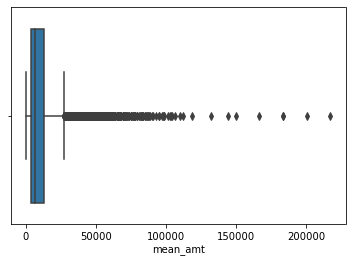

In [50]:
import seaborn as sns
sns.boxplot(data=df_base,x="mean_amt")

## 対象のIDの数名の購買行動

### 一旦対象IDを選んでみた

In [65]:
# query = """
# WITH base AS(
#     SELECT salesday, FORMAT_TIMESTAMP("%m", salesday) AS month, customercd, posno, tradeno, jan, salescnt, salesamount
#     FROM `inunaki.dwd_cdp_0001.dwd_cdp_idpos_detail`
#   WHERE salesday BETWEEN "2022-07-01" AND "2023-06-30"
#     -- WHERE salesday BETWEEN "2023-06-01" AND "2023-06-30"
#     AND customercd <> "0"
#     AND customercd IN (
#        'd7ce5c9f3b2cadea12296609e5d95b08',
#        '020dd0541b951722dd5e943041fe38e2',
#        '460f0b7a29018342b899838e1a7f8a6d',
#        '1fd0a245df6af741ed2fa91b18e53668',
#        'f7e7b9e8fc8cc9f9d4178e6a93c44249',
#        '5def3d31a9b1729f4b9bd5927d726b67',
#        '9dfa2491d25e42a950dc3a55d6bc5bed',
#        'cc4f48a982ea0b32b00a19da01a8a25d',
#        'bf548ff47ad64930b3312b95fa0938f9',
#        'eb4e2f0595197014f8b7db90e5085e04',
#        '5f02caac0023bb3fa5c0d37861b6d7bf',
#        '67ce55c5472c4c116c2354c2fa7f6d26',
#        '29d4d3a639939236ea1e917bcd325b1d',
#        'b60b34a800cf746fc9ac8fae521a3723',
#        'a8dd8896d900a2b1c13fb51e4dd05ce4',
#        'f0ab3723480d226d0650292b0a6e8583'
#     )
#     AND storecd = 473
# ),
# -- ライフステージの情報を足す
# lifestage_temp AS (
#   SELECT 
#     ym, customer_id,
#   CASE
#       WHEN single = "1" THEN "単身"
#       WHEN dewks = "1" THEN "DEWKS"
#       WHEN dinks = "1" THEN "DINKS"
#   ELSE "老年夫婦"
#   END AS lifestage,
#   ROW_NUMBER() OVER(PARTITION BY customer_id ORDER BY ym DESC) AS number
#   FROM `inunaki.dws_cdp_0001.dws_customer_wide_tags` lifestage
#   WHERE ym >= "2022-04-01"
# ),
# lifestage_data AS(
#   SELECT DISTINCT customer_id, lifestage
#   FROM lifestage_temp
#   WHERE number = 1
# )
# SELECT salesday, month, base.customercd, age, sex, posno, tradeno, lifestage, organizationname, divisionname, linename, 
# departmentname, categoryname, base.jan, janname, salescnt, salesamount
# FROM base
# LEFT JOIN lifestage_data
# ON base.customercd = lifestage_data.customer_id
# LEFT JOIN `inunaki.dim_common_0001.dim_crm_customer_info` age_data
# ON base.customercd = age_data.customercd
# LEFT JOIN `inunaki.dim_common_0001.dim_product` product
# ON base.jan = product.jan
# """

# # #データフレームに変換
# df2 = client.query(query).to_dataframe()
# df2.to_csv("data/顧客理解ws_購買データ.csv",index=False)

In [66]:
df_id_data = pd.read_csv("data/顧客理解ws_購買データ.csv")
df_id_data["salesday"] = pd.to_datetime(df_id_data["salesday"])

In [67]:
# 従業員を外す
df_no_j = pd.DataFrame(abcd.query("jugyoin_flg==0")["customercd"].unique(),columns={"customercd"})
df_id_data = df_id_data.merge(df_no_j,on="customercd") 

In [68]:
len(df_no_j)

16

In [69]:
df_id_data["customercd"].nunique()

16

0:女性 \
1：男性 \
9:不明

In [70]:
df_id_data.loc[df_id_data["sex"]==0, "性別"] = "女性"
df_id_data.loc[df_id_data["sex"]==1, "性別"] = "男性"
df_id_data.loc[df_id_data["sex"]==9, "性別"] = "不明"

In [71]:
df_id_data.head()

,salesday,month,customercd,age,sex,posno,tradeno,lifestage,organizationname,divisionname,linename,departmentname,categoryname,jan,janname,salescnt,salesamount,性別
0,2022-07-31,7,67ce55c5472c4c116c2354c2fa7f6d26,45,0,2501,4656,DEWKS,ハード,カルチャー・ペット,ペット,ペット水物,水槽用品,4972814533615,薄型高密度マット,1,199,女性
1,2022-10-16,10,67ce55c5472c4c116c2354c2fa7f6d26,45,0,1034,8407,DEWKS,ハード,カルチャー・ペット,ペット,ペット水物,水槽用品,4972814533615,薄型高密度マット,1,199,女性
2,2022-07-12,7,67ce55c5472c4c116c2354c2fa7f6d26,45,0,1021,6512,DEWKS,ディリーグループ,和日配,和日配,和惣菜,佃煮・煮豆・惣菜,4901482161813,とく盛甘口ふきしいたけ,1,299,女性
3,2022-11-20,11,67ce55c5472c4c116c2354c2fa7f6d26,45,0,2505,4284,DEWKS,ディリーグループ,和日配,和日配,和惣菜,佃煮・煮豆・惣菜,4901482161813,とく盛甘口ふきしいたけ,1,239,女性
4,2022-08-28,8,67ce55c5472c4c116c2354c2fa7f6d26,45,0,3401,662,DEWKS,ハード,カルチャー・ペット,ペット,ペット水物,水槽用品,4972814533615,薄型高密度マット,1,199,女性


### 月毎の集計値

In [72]:
df_id_data["年月"] = df_id_data["salesday"].dt.strftime("%Y%m")

In [73]:
# 月毎の集計値を出す
df_month_data = df_id_data.groupby(["salesday","customercd","age","lifestage","性別","年月"]).agg({"salescnt":"sum","salesamount":"sum"}).reset_index()\
.groupby(["customercd","age","lifestage","性別","年月"]).agg({"salescnt":"sum","salesamount":"sum","salesday":"count"}).reset_index()

# 月毎の購入ディビジョン数を出す
df_cate = df_id_data[["customercd","年月","organizationname","divisionname","linename","departmentname","categoryname"]].drop_duplicates()
df_cate = df_cate.groupby(["customercd","年月"]).agg({"categoryname":"count"}).reset_index()

df_month_data = df_month_data.merge(df_cate,on=["customercd","年月"])

In [74]:
# 黒字のデータを入れいる
df_kuroji_id = abcd[["customercd","cost","sale","rieki"]]
df_month_data = df_month_data.merge(df_kuroji_id,on="customercd")

In [75]:
df_month_data = df_month_data.rename(columns={"customercd":"顧客ID","age":"年代",
                              "lifestage":"ライフステージ",
                              "salescnt":"売上数量","salesamount":"売上金額",
                              "salesday":"来店回数","categoryname":"購入カテゴリ数",
                                             "cost":"コスト","sale":"セール","rieki":"利益"})

In [76]:
df_month_data.head()

,顧客ID,年代,ライフステージ,性別,年月,売上数量,売上金額,来店回数,購入カテゴリ数,コスト,セール,利益
0,020dd0541b951722dd5e943041fe38e2,40,DEWKS,女性,202207,186,35081,9,68,1.408841e+06,1770746,361904.569885
1,020dd0541b951722dd5e943041fe38e2,40,DEWKS,女性,202208,283,56340,11,54,1.408841e+06,1770746,361904.569885
2,020dd0541b951722dd5e943041fe38e2,40,DEWKS,女性,202209,745,150806,18,104,1.408841e+06,1770746,361904.569885
3,020dd0541b951722dd5e943041fe38e2,40,DEWKS,女性,202210,739,163162,21,109,1.408841e+06,1770746,361904.569885
4,020dd0541b951722dd5e943041fe38e2,40,DEWKS,女性,202211,893,197033,23,128,1.408841e+06,1770746,361904.569885


In [77]:
df_month_data.to_csv("顧客理解ws_集計値.csv",index=False)

### 月毎の購入ランキング

In [78]:
df_ranking_kounyu = df_id_data.groupby(["month","customercd","organizationname","divisionname","linename","departmentname","categoryname","janname"])\
.agg({"salesamount":"sum","salescnt":"sum"}).reset_index()

In [79]:
df_ranking_kounyu = df_ranking_kounyu.rename(columns={"customercd":"顧客ID","organizationname":"事業部名","month":"月",
                              "divisionname":"ディビジョン名","linename":"ライン名",
                              "departmentname":"部門名","categoryname":"カテゴリ名",
                              "janname":"商品名","salesamount":"商品購入金額","salescnt":"商品購入数量"})

In [80]:
df_ranking_kounyu.head()

,月,顧客ID,事業部名,ディビジョン名,ライン名,部門名,カテゴリ名,商品名,商品購入金額,商品購入数量
0,1,020dd0541b951722dd5e943041fe38e2,グロサリー,グロサリー,グロサリー,加工食品,素材缶詰・瓶詰,シャキッとコーン,267,1
1,1,020dd0541b951722dd5e943041fe38e2,グロサリー,グロサリー,グロサリー,和風調味料,しょうゆ,あまかっちゃん しょうゆ,309,1
2,1,020dd0541b951722dd5e943041fe38e2,グロサリー,グロサリー,グロサリー,和風調味料,しょうゆ,いつでも新鮮_九州うまくち_まろやかしょうゆ,279,1
3,1,020dd0541b951722dd5e943041fe38e2,グロサリー,グロサリー,グロサリー,和風調味料,しょうゆ,うすくちしょうゆ,1813,7
4,1,020dd0541b951722dd5e943041fe38e2,グロサリー,グロサリー,グロサリー,和風調味料,しょうゆ,特級うまくちしょうゆ,1914,6


In [81]:
df_ranking_kounyu.to_csv("顧客理解ws_購入商品.csv",index=False)

In [82]:
# df_ranking_kounyu.merge(df_month_data,on=["月","顧客ID"]).to_csv("顧客理解ws_集計と購入商品.csv",index=False)

In [83]:
# df_ranking_kounyu.merge(df_month_data,on=["月","顧客ID"])

In [84]:
# 曜日
def youbi_name(x):
    if  x == 0:
        return "月"
    elif x == 1:
        return "火"
    if  x == 2:
        return "水"
    elif x == 3:
        return "木"
    if  x == 4:
        return "金"
    elif x == 5:
        return "土"
    else:
        return "日"

In [85]:
# 曜日を追加する
df_id_data["youbi"] = df_id_data["salesday"].dt.weekday
df_id_data["曜日"] = df_id_data["youbi"].apply(youbi_name)

In [112]:
# 商品名と個数を足す
df_id_data["janname_cnt"] = df_id_data["janname"] + ":" + df_id_data["salescnt"].astype(str)

# 商品名を作る
df_day_data = df_id_data.groupby(["salesday","曜日","customercd"]).agg({'janname_cnt': lambda x: ' / '.join(x)}).reset_index()

In [113]:
# 日毎の集計値を出す
df_day_shukei = df_id_data.groupby(["salesday","customercd"]).agg({"salescnt":"sum","salesamount":"sum"}).reset_index()

# 来店間隔を出す
test_hindo = df_day_shukei.sort_values("salesday")
test_hindo["shift_date"] = test_hindo.groupby(["customercd"])["salesday"].shift(-1)
test_hindo = test_hindo.dropna()
test_hindo["hindo"] =  (test_hindo["shift_date"] - test_hindo["salesday"]).dt.days

test_hindo = test_hindo[["shift_date","customercd","hindo"]].rename(columns={"shift_date":"salesday"})
# 来店間隔も追加する
df_day_shukei = df_day_shukei.merge(test_hindo,on=["salesday","customercd"],how="left").fillna(0)

In [115]:
df_day_data = df_day_data.merge(df_day_shukei,on=["salesday","customercd"],how="left")

In [120]:
df_day_data = df_day_data.rename(columns={"customercd":"顧客ID","salesday":"日付","janname_cnt":"購入履歴","salescnt":"売上数量","salesamount":"売上金額","hindo":"前回からの来店間隔"})
df_day_data.to_csv("顧客理解ws_日毎の購入状況.csv",index=False)

In [119]:
df_day_data.head()

,日付,曜日,顧客ID,購入履歴,売上数量,売上金額,前回からの来店間隔
0,2022-07-01,金,29d4d3a639939236ea1e917bcd325b1d,ギャツビー アイスデオドラント ボディペーパー アイスシャボン:1 / ビオレｕ フレッシュ...,24,4794,0.0
1,2022-07-01,金,460f0b7a29018342b899838e1a7f8a6d,チキンモヤサラダ３Ｐ:1 / 揖保の糸素麺:2 / さけるチーズとうがらし:2 / 蒟蒻畑レ...,24,4844,0.0
2,2022-07-01,金,5f02caac0023bb3fa5c0d37861b6d7bf,クルマ用ファブリーズ:1 / 三ツ矢サイダー1.5L:1 / GREENDAKARAミルコア...,27,2133,0.0
3,2022-07-01,金,67ce55c5472c4c116c2354c2fa7f6d26,海鮮漬け丼:1 / 米の蔵詩 25度 米 パック:1 / 北海道産 真ホッケ開き:1 / 毎...,44,8224,0.0
4,2022-07-01,金,9dfa2491d25e42a950dc3a55d6bc5bed,スルメイカ輪切り:1 / 赤霧島25度芋パック:1 / 尾付きむきえび:1 / ミックス卵:...,42,7980,0.0
